# Combined approach for Multilabel Binary Classification (MBC) and Regression

⚠️ **Important:** This notebook is **Step 3**. You must complete **Step 1** and **Step 2** before running it.

---

### Pipeline Overview

1. **Step 1 — Run inside the PorePy environment**  
   **Input:** Model setup and fracture configuration.  
   **Output:**  
   - Mesh files: `mesh2d_Xfr_id.msh`  
   - Fracture metadata: `mesh_meta_id.json`  
   - Solver log: `solver_times.csv` (convergence, solve time, etc.)  

   **Example:**  
   `D:/MLpmg/Data_Large4` contains 4000 meshes, matching fracture files with IDs in `0.4d` format, and one `solver_times.csv`.

---

2. **Step 2 — Create the feature dataset** *(this notebook)*  
   **Input:**  
   - Mesh files `*.msh`  
   - Fracture metadata `*.json`  
   - Solver log `solver_times.csv`  

   **Output:**  
   - Feature table `mesh_features.csv` combining mesh geometry, fracture stats, and solver outcomes.  

   **Usage example:**
   ```python
   from dataset_builder import MeshFeatureDatasetBuilder

   builder = MeshFeatureDatasetBuilder(
       mesh_dir="D:/ML4pmg/Data_Large4/",
       solver_csv="D:/ML4pmg/Data_Large4/solver_times.csv",
       output_csv="D:/ML4pmg/Data_Large4/mesh_features.csv",
       log_transform=True
   )
   
---

3. **Step 3 – Run `Clf_and_Reg_Combined.ipynb`**  
   - Train models and generate predictions.  
   - Compare results against baseline and clairvoyant approaches.






We  have two levels of data imbalance:  
  ( Level 1 ) convergene pattern imbalance across meshes (mesh imblance);   
            Example: '000'- 60%, '011' - 30%, '010' - 9%, '100' - 1%
            This causes a problem for classification. Possible solutions - resampling, or weigted entropy loss 

  ( Level 2 ) some solvers rarely converge (solver imbalance); 
            Example: from the example above,  data present for y1 - 1%, y2 - 39%, y3 - 0%
           


Dataset with mesh-features 
`D:/ML4pmg/Data_Large23/mesh_features.csv `            

Dataset with mesh and fracture-features  
`D:/ML4pmg/Data_Large4/mesh_features.csv `     

The user is not restricted to any specific features and datasets though, as this part is rather general




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import lightgbm as lgb



In [2]:
df = pd.read_csv("D:/ML4pmg/Data_Large4/mesh_features.csv")
df.head()

,mesh_name,mesh_id,n_elements,n_nodes,n_fractures,area_mean,area_median,area_std,area_5pct,area_95pct,...,length_95pct,length_min,length_max,orientation_mean,orientation_median,orientation_std,orientation_5pct,orientation_95pct,orientation_min,orientation_max
0,mesh2d_Xfr_0000.msh,0,11307,5741,48,0.000088,0.000043,0.000135,6.767622e-07,0.000329,...,1.829593,0.104775,3.795583,-0.018859,0.770763,1.898441,-2.868408,2.392400,-3.129456,2.974126
1,mesh2d_Xfr_0001.msh,1,9734,4957,41,0.000103,0.000058,0.000134,1.539556e-06,0.000368,...,1.685658,0.035910,2.142718,0.143106,0.923600,2.016992,-2.951769,2.595133,-3.066049,2.834920
2,mesh2d_Xfr_0002.msh,2,19860,10017,53,0.000050,0.000018,0.000106,2.606839e-07,0.000198,...,2.175067,0.209778,4.199006,0.870995,1.204647,1.884652,-2.856945,3.035712,-3.136452,3.121978
3,mesh2d_Xfr_0003.msh,3,15268,7720,45,0.000065,0.000024,0.000117,3.149339e-07,0.000282,...,1.427018,0.051710,2.114722,0.366699,0.986031,1.877151,-2.470862,2.994755,-3.099135,3.084871
4,mesh2d_Xfr_0004.msh,4,21710,10925,54,0.000046,0.000007,0.000111,1.556122e-08,0.000222,...,1.628979,0.061014,4.597640,0.035577,0.732041,2.154126,-2.912721,2.794167,-3.084889,3.056958


Summary of the dataset: 

In [3]:
print(f"Data shape: {df.shape}")
print(*df.columns, sep="\n")

Data shape: (4000, 111)
mesh_name
mesh_id
n_elements
n_nodes
n_fractures
area_mean
area_median
area_std
area_5pct
area_95pct
area_min
area_max
signed_area_mean
signed_area_median
signed_area_std
signed_area_5pct
signed_area_95pct
signed_area_min
signed_area_max
rms_edge_mean
rms_edge_median
rms_edge_std
rms_edge_5pct
rms_edge_95pct
rms_edge_min
rms_edge_max
volume_length_metric_mean
volume_length_metric_median
volume_length_metric_std
volume_length_metric_5pct
volume_length_metric_95pct
volume_length_metric_min
volume_length_metric_max
min_angle_mean
min_angle_median
min_angle_std
min_angle_5pct
min_angle_95pct
min_angle_min
min_angle_max
max_angle_mean
max_angle_median
max_angle_std
max_angle_5pct
max_angle_95pct
max_angle_min
max_angle_max
grading_ratio_mean
grading_ratio_median
grading_ratio_std
grading_ratio_5pct
grading_ratio_95pct
grading_ratio_min
grading_ratio_max
y_time_0
y_time_1
y_time_2
y_time_3
y_time_4
y_time_5
y_time_6
y_time_7
y_time_8
y_time_9
y_time_10
y_time_11
y_tim

## Data pre-processing

-  From the data `X` by extracting the correct columns, form `Yconv` and `Yref`, for classification and regression labels, respectively;    
-  Revomove columns in `Yconv` and `Yreg` that do not carry any information (basically contant throughout the dataset), to obtain `Yc` and `Yr`

### Forming `X`, `Yconv`, `Yreg`

In [4]:
pattern_col = "convergence_pattern" # if annotated dataset is used

time_cols = sorted([c for c in df.columns if c.startswith("y_time_")],
                   key=lambda s: int(s.split("y_time_")[1]))

conv_cols = sorted([c for c in df.columns if c.startswith("y_conv_")],
                   key=lambda s: int(s.split("y_conv_")[1]))

excluded_cols = time_cols + conv_cols + ['mesh_name', 'mesh_id','pattern_id'] #+ [pattern_col]

feature_cols = [c for c in df.columns if c not in excluded_cols]



In [5]:
X = df[feature_cols].values
#X = df[selected].values; # is feature engineering applied!

Yconv = df[conv_cols].values.astype(int)
Yreg =df[time_cols].values


print(f' Dataset X of {X.shape} with classification labels  Yconv of {Yconv.shape} and regression labels Yreg of {Yreg.shape}')

n_solvers = Yconv.shape[1]

 Dataset X of (4000, 73) with classification labels  Yconv of (4000, 18) and regression labels Yreg of (4000, 18)


In [6]:
dfs = pd.read_csv('D:/ML4pmg/Data_Large4/solver_times.csv')
SolverLabels=dfs['Solver Label'][0:n_solvers]
SolverLabels.tolist()

['gmres + ilu + ilu',
 'gmres + sor + ilu',
 'gmres + jacobi + ilu',
 'gmres + bjacobi + ilu',
 'gmres + asm + ilu',
 'gmres + gamg + ilu',
 'bcgs + ilu + ilu',
 'bcgs + sor + ilu',
 'bcgs + jacobi + ilu',
 'bcgs + bjacobi + ilu',
 'bcgs + asm + ilu',
 'bcgs + gamg + ilu',
 'tfqmr + ilu + ilu',
 'tfqmr + sor + ilu',
 'tfqmr + jacobi + ilu',
 'tfqmr + bjacobi + ilu',
 'tfqmr + asm + ilu',
 'tfqmr + gamg + ilu']

### Forming `Yc` and `Yr`

Obtain the statistis of per solver succeseful converngence and display it

In [7]:
N, m = Yconv.shape
solver_stats = []
for j in range(m):
    num_1 = int(Yconv[:, j].sum())
    num_0 = int(N - num_1)

    if num_1 == 0:
        status = "always diverged"
    elif num_0 == 0:
        status = "always converged"
    else:
        status = "mixed"

    solver_stats.append({
        "status": status,
        "num_ones": num_1,
        "num_zeros": num_0,
        "convergence_proportion": num_1 / N
    })

# Convert to DataFrame for inspection
solver_df = pd.DataFrame(solver_stats)
print(solver_df)


             status  num_ones  num_zeros  convergence_proportion
0   always diverged         0       4000                 0.00000
1   always diverged         0       4000                 0.00000
2   always diverged         0       4000                 0.00000
3   always diverged         0       4000                 0.00000
4   always diverged         0       4000                 0.00000
5             mixed       682       3318                 0.17050
6             mixed      1831       2169                 0.45775
7   always diverged         0       4000                 0.00000
8   always diverged         0       4000                 0.00000
9             mixed      1831       2169                 0.45775
10            mixed      1831       2169                 0.45775
11            mixed      2250       1750                 0.56250
12            mixed       321       3679                 0.08025
13  always diverged         0       4000                 0.00000
14  always diverged      

Remove the constant columns, i.e., keep only 'mixed'

In [8]:
diverged_mask = solver_df["status"] == "always diverged"
diverged_indices = solver_df.index[diverged_mask].to_list()

Aux = Yreg[:, diverged_indices]
Y_penalty = Aux.max(); T_penalty = np.exp(-Y_penalty)  # back from log-time to time

print(f" - Solver indices that always diverged: {diverged_indices}")

converged_mask = solver_df["status"] == "always converged"
converged_indices = solver_df.index[converged_mask].to_list()

print(f" - Solver indices that always converged: {converged_indices}")


mixed_mask = solver_df["status"] == "mixed"
mixed_indices = solver_df.index[mixed_mask].to_list()

Yc= Yconv[:,mixed_indices]
Yr = Yreg[:, mixed_indices]

print(f" - Solver indices with mixed convergence: {mixed_indices}")
NewLabels =SolverLabels[mixed_indices]
print(NewLabels)

print(f"The classification labels Yc are of {Yc.shape} and regression labels Yr are of {Yr.shape}")
print(f"The max log-time Y_penalty is set to {Y_penalty:.2f}, or equivalently actual time to T_penalty = {T_penalty:.2f} [seconds]")


 - Solver indices that always diverged: [0, 1, 2, 3, 4, 7, 8, 13, 14]
 - Solver indices that always converged: []
 - Solver indices with mixed convergence: [5, 6, 9, 10, 11, 12, 15, 16, 17]
5        gmres + gamg + ilu
6          bcgs + ilu + ilu
9      bcgs + bjacobi + ilu
10         bcgs + asm + ilu
11        bcgs + gamg + ilu
12        tfqmr + ilu + ilu
15    tfqmr + bjacobi + ilu
16        tfqmr + asm + ilu
17       tfqmr + gamg + ilu
Name: Solver Label, dtype: object
The classification labels Yc are of (4000, 9) and regression labels Yr are of (4000, 9)
The max log-time Y_penalty is set to -1.58, or equivalently actual time to T_penalty = 4.85 [seconds]


In [9]:
Best_of_all = np.argmax(Yr, axis=1)
row_all_zero=(np.sum(Yc,axis =1)==0)
Best_of_all[row_all_zero]= -1  # No solver converged
print(f'How many times these solvers were the best: \n(-1 means no solver converged, otherwise it is the index of the best (renumerated) solver)')
print(Counter(Best_of_all))

How many times these solvers were the best: 
(-1 means no solver converged, otherwise it is the index of the best (renumerated) solver)
Counter({-1: 1400, 1: 770, 2: 751, 4: 543, 3: 285, 8: 219, 6: 13, 5: 10, 0: 7, 7: 2})


In [10]:
Yr.shape

(4000, 9)

### Some useful statistics on the processed data:

In [11]:
pos = Yc.sum(axis=0)
neg = Yc.shape[0] - pos
w   = neg / np.maximum(pos, 1)
data = {}

data["pos"]  = pos
data["neg"]  = neg
data["scale_pos_weight"] = w

overview = pd.DataFrame(data)
overview.insert(0, ("solver_name"), NewLabels.tolist())
overview.insert(0, ("solver_idx"), np.arange(Yc.shape[1]) + 1)

print(overview)


   solver_idx            solver_name   pos   neg  scale_pos_weight
0           1     gmres + gamg + ilu   682  3318          4.865103
1           2       bcgs + ilu + ilu  1831  2169          1.184599
2           3   bcgs + bjacobi + ilu  1831  2169          1.184599
3           4       bcgs + asm + ilu  1831  2169          1.184599
4           5      bcgs + gamg + ilu  2250  1750          0.777778
5           6      tfqmr + ilu + ilu   321  3679         11.461059
6           7  tfqmr + bjacobi + ilu   321  3679         11.461059
7           8      tfqmr + asm + ilu   321  3679         11.461059
8           9     tfqmr + gamg + ilu  2185  1815          0.830664


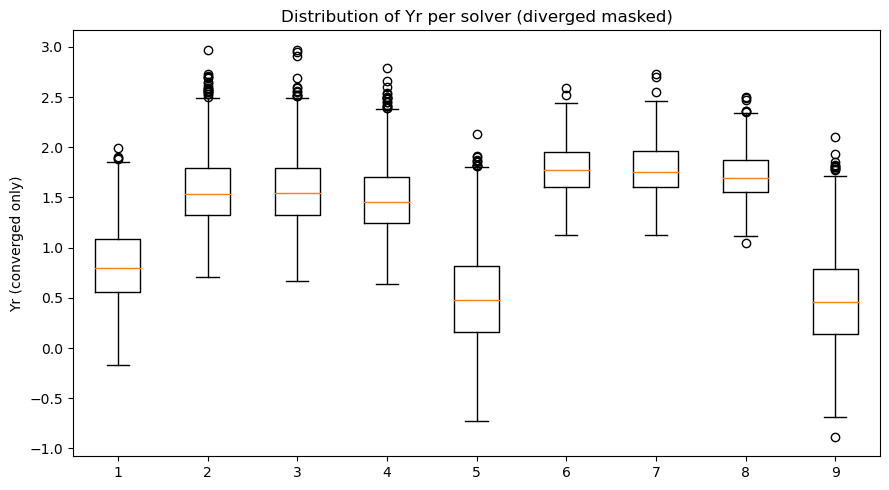

In [12]:
# Mask diverged entries in Yr
Mask = (Yc == 0)                    # diverged
Aux = Yr.copy(); Aux[Mask] = np.nan

# Boxplot per solver (columns), ignoring NaNs
data = [Aux[:, j][~np.isnan(Aux[:, j])] for j in range(Aux.shape[1])]
plt.figure(figsize=(max(8, Aux.shape[1]*1.0), 5))
plt.boxplot(data, showfliers=True)

#plt.xticks(range(1, Aux.shape[1]+1), NewLabels, rotation=45, ha='right')
plt.ylabel("Yr (converged only)")
plt.title("Distribution of Yr per solver (diverged masked)")
plt.tight_layout()
plt.show()

    


## Split dataset into Train, Validation, and Test 
We need to try and ensure a balance in the split, guided by statistics of the Training Set labels `Yc_tr`. 

There three options below: Multilabel- aware split, Stratified split by number of positives per row, and Random split.  
Control the choice with `choice` selecting between `{'multilabel-aware-split', 'stratified','random'}`


In [13]:
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit as MLSSS

from sklearn.metrics import (
    precision_recall_curve, f1_score, precision_score, recall_score,
    accuracy_score, average_precision_score, roc_auc_score )

In [14]:

def split_data(X, Yc, Yr, choice="multilabel-aware-split", random_state=42):
    """
    Split data into train, validation, and test sets.
    
    Parameters
    ----------
    X : array-like, shape (N, n)
        Feature matrix.
    Yc : array-like, shape (N, m)
        Classification labels (multilabel).
    Yr : array-like, shape (N, m), optional
        Regression labels.
    choice : str
        Split strategy: 'multilabel-aware-split', 'stratified', or 'random'.
    random_state : int
        Random seed.
    
    Returns
    -------
    (X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te)
    """
    if choice == "multilabel-aware-split":
        msss = MLSSS(n_splits=1, test_size=0.2, random_state=random_state)
        trval_idx, te_idx = next(msss.split(X, Yc))

        msss2 = MLSSS(n_splits=1, test_size=0.25, random_state=random_state)
        tr_idx, val_idx = next(msss2.split(X[trval_idx], Yc[trval_idx]))

        tr_idx = trval_idx[tr_idx]
        val_idx = trval_idx[val_idx]

        print("✔ Used multilabel stratified split (train/val/test).")
        return (
        X[tr_idx], X[val_idx], X[te_idx],
        Yc[tr_idx], Yc[val_idx], Yc[te_idx],
        Yr[tr_idx], Yr[val_idx], Yr[te_idx]
    )

    elif choice == "stratified":
        row_sum = Yc.sum(axis=1)
        X_trval, X_te, Yc_trval, Yc_te, Yr_trval, Yr_te = train_test_split(
            X, Yc, Yr, test_size=0.2, stratify=row_sum, random_state=random_state
        )
        strat = row_sum[X_trval.index] if hasattr(X_trval, "index") else None
        X_tr, X_val, Yc_tr, Yc_val, Yr_tr, Yr_val = train_test_split(
            X_trval, Yc_trval, Yr_trval, test_size=0.25, stratify=strat, random_state=random_state
        )
        print("✔ Used stratify by positives count per row (train/val/test).")
        return X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te

    else:
        X_trval, X_te, Yc_trval, Yc_te, Yr_trval, Yr_te = train_test_split(
            X, Yc, Yr, test_size=0.2, random_state=random_state
        )
        X_tr, X_val, Yc_tr, Yc_val, Yr_tr, Yr_val = train_test_split(
            X_trval, Yc_trval, Yr_trval, test_size=0.25, random_state=random_state
        )
        print("⚠️ Used random split (train/val/test, no stratification).")
        return X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te


In [15]:
def make_weights_table(Yc_tr, Yc_val, Yc_te):
    """
    Make a diagnostic table of class weights for each solver in train, val, and test sets.
    """
    splits = {"train": Yc_tr, "val": Yc_val, "test": Yc_te}
    data = {}

    for split, Y in splits.items():
        pos = Y.sum(axis=0)
        neg = Y.shape[0] - pos
        w   = neg / np.maximum(pos, 1)

        data[(split, "pos")]  = pos
        data[(split, "neg")]  = neg
        data[(split, "scale_pos_weight")] = w

    weights_df = pd.DataFrame(data)
    weights_df.insert(0, ("", "solver_idx"), np.arange(Yc_tr.shape[1]) + 1)
    return weights_df

In [16]:
choice='multilabel-aware-split'
#choice='stratified'
#choice='random'

X_tr, X_val, X_te, Yc_tr, Yc_val, Yc_te, Yr_tr, Yr_val, Yr_te = split_data(X, Yc, Yr, choice=choice, random_state=42)
print(f"Train: {len(X_tr)} | Val: {len(X_val)} | Test: {len(X_te)}")



weights_df = make_weights_table(Yc_tr, Yc_val, Yc_te)
print(weights_df)





✔ Used multilabel stratified split (train/val/test).
Train: 2400 | Val: 800 | Test: 800
             train                         val                       test  \
  solver_idx   pos   neg scale_pos_weight  pos  neg scale_pos_weight  pos   
0          1   410  1990         4.853659  136  664         4.882353  136   
1          2  1099  1301         1.183803  366  434         1.185792  366   
2          3  1099  1301         1.183803  366  434         1.185792  366   
3          4  1099  1301         1.183803  366  434         1.185792  366   
4          5  1350  1050         0.777778  450  350         0.777778  450   
5          6   193  2207        11.435233   64  736        11.500000   64   
6          7   193  2207        11.435233   64  736        11.500000   64   
7          8   193  2207        11.435233   64  736        11.500000   64   
8          9  1311  1089         0.830664  437  363         0.830664  437   

                         
   neg scale_pos_weight  
0  664      

## Selecting best model

this could be improved by selecting ranges or castomizing scalings or training set up

In [17]:

from sklearn.metrics import average_precision_score

m = Yc_tr.shape[1]


n_trials = 50 # how many random tries per solver
display_every_n = 10 # increase if do not need verbose output

clf_models = []
best_params_per_solver = []
best_val_ap_per_solver = []
Ap = np.zeros((n_trials,m))

# --- base (shared) params; candidates will override some of these ---
base_params = {
    "objective": "binary",
    "n_estimators": 5000,
    "learning_rate": 0.05,
    "max_depth": 8,
    "num_leaves": 15,
    "min_data_in_leaf": 8,
    "max_bin": 511,
    "feature_fraction": 1.0,
    "bagging_fraction": 1.0,
    "random_state": 24,
    "n_jobs": -1,
    "verbose": -1 
}

rng = np.random.RandomState(24)

def sample_params(rng):
    return {
        # Continuous range
        "learning_rate": rng.uniform(0.01, 0.1),      

        # Discrete integer ranges
        "num_leaves": int(rng.randint(15, 64)),       # 15..63
        "max_depth": int(rng.choice([-1, 6, 8, 10])), # -1 = any depth, controlled by other parameters; 
        "min_data_in_leaf": int(rng.randint(20, 101)), # 20..100
        "max_bin": int(rng.choice([255, 511, 1251])),  # Binning for continues features 

        # Continuous fractions
        "feature_fraction": rng.uniform(0.6, 1.0),    
        "bagging_fraction": rng.uniform(0.6, 1.0),    

        # Discrete freq
        "bagging_freq": int(rng.choice([0, 1, 5])), # how often (in terms of boosting rounds) to perform bagging

        # Regularization, continuous 
        "lambda_l1": rng.uniform(0.0, 1.0),           
        "lambda_l2": rng.uniform(0.0, 5.0),           

        # Split gain threshold
        "min_gain_to_split": rng.uniform(0.0, 0.2),   
    }



for j in range(m):
    print(f'Training model for solver {j+1}/{m}...')
    ytr = Yc_tr[:, j]
    yval = Yc_val[:, j]

    best_ap = -1.0
    best_clf = None
    best_params = None

    for t in range(1, n_trials + 1):
        cand = {**base_params, **sample_params(rng)}
        clf = lgb.LGBMClassifier(**cand, scale_pos_weight= 1.0) #=scale_pos_weights[j]
        clf.fit(
            X_tr, ytr,
            eval_set=[(X_val, yval)],
            eval_metric="aucpr", #"binary_logloss",             # threshold-free metric for early stopping
            callbacks=[lgb.early_stopping(200, verbose=False)]
        )

        # Select by validation AP (threshold-free)
        p_val = clf.predict_proba(X_val)[:, 1]
        ap = average_precision_score(yval, p_val)
        Ap[t-1,j]= ap

        if ap > best_ap:
            best_ap = ap
            best_clf = clf
            best_params = cand

        if t % display_every_n == 0 or t == n_trials:
            print(f"  trial {t}/{n_trials} | best val AP so far: {best_ap:.4f}")

    clf_models.append(best_clf)
    best_params_per_solver.append(best_params)
    best_val_ap_per_solver.append(best_ap)
    print(f"✔ Solver {j+1}: selected model with val AP = {best_ap:.4f}")

print("✔ Trained & selected best per-solver classifiers based on validation AP.")


Training model for solver 1/9...
  trial 10/50 | best val AP so far: 0.7647
  trial 20/50 | best val AP so far: 0.7763
  trial 30/50 | best val AP so far: 0.7763
  trial 40/50 | best val AP so far: 0.7763
  trial 50/50 | best val AP so far: 0.7763
✔ Solver 1: selected model with val AP = 0.7763
Training model for solver 2/9...
  trial 10/50 | best val AP so far: 0.9565
  trial 20/50 | best val AP so far: 0.9570
  trial 30/50 | best val AP so far: 0.9570
  trial 40/50 | best val AP so far: 0.9570
  trial 50/50 | best val AP so far: 0.9570
✔ Solver 2: selected model with val AP = 0.9570
Training model for solver 3/9...
  trial 10/50 | best val AP so far: 0.9556
  trial 20/50 | best val AP so far: 0.9583
  trial 30/50 | best val AP so far: 0.9583
  trial 40/50 | best val AP so far: 0.9583
  trial 50/50 | best val AP so far: 0.9583
✔ Solver 3: selected model with val AP = 0.9583
Training model for solver 4/9...
  trial 10/50 | best val AP so far: 0.9568
  trial 20/50 | best val AP so far: 

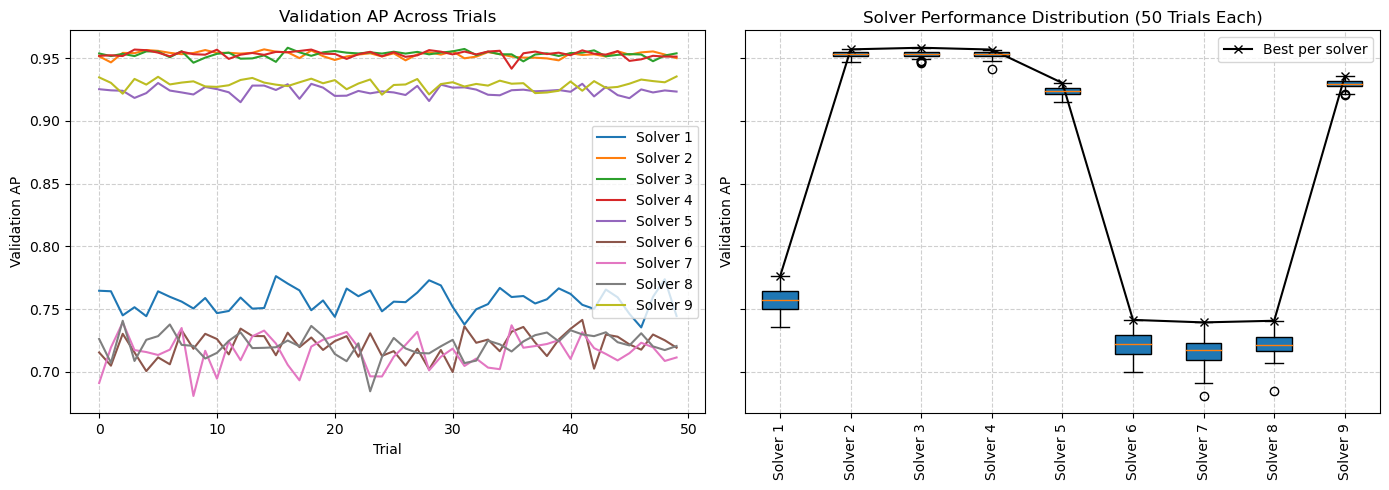

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Left plot: AP evolution over trials ---
for j in range(Ap.shape[1]):
    axes[0].plot(Ap[:, j], label=f"Solver {j+1}")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Validation AP")
axes[0].set_title("Validation AP Across Trials")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.6)

# --- Right plot: Boxplot + best values ---
bp = axes[1].boxplot(
    Ap,
    labels=[f"Solver {j+1}" for j in range(Ap.shape[1])],
    patch_artist=True
)
# Overlay best values
x = np.arange(1, len(best_val_ap_per_solver) + 1)
axes[1].plot(x, best_val_ap_per_solver, '-x', color="black", label="Best per solver")

axes[1].set_xticklabels([f"Solver {j+1}" for j in range(Ap.shape[1])], rotation=90)
axes[1].set_ylabel("Validation AP")
axes[1].set_title(f"Solver Performance Distribution ({n_trials} Trials Each)")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

Display best parameters for each solver, if you like to do some diagnostics...

In [19]:
best_params_per_solver[6] 

{'objective': 'binary',
 'n_estimators': 5000,
 'learning_rate': 0.08734243143933251,
 'max_depth': 10,
 'num_leaves': 23,
 'min_data_in_leaf': 56,
 'max_bin': 511,
 'feature_fraction': 0.8111236203696921,
 'bagging_fraction': 0.8470333678356112,
 'random_state': 24,
 'n_jobs': -1,
 'verbose': -1,
 'bagging_freq': 5,
 'lambda_l1': 0.839179797720372,
 'lambda_l2': 2.109214217496795,
 'min_gain_to_split': 0.11346482327414315}

### EVALUATION

In [20]:
from sklearn.metrics import precision_recall_curve

def best_threshold_from_pr(y_true, y_prob, beta=1.0, target=None):

    """
    Choose threshold from the precision–recall curve.
    - If target is None: maximize F_beta (F1 by default).
    - If target={"precision": p}: meet precision>=p, then maximize recall.
    - If target={"recall": r}: meet recall>=r, then maximize precision.
    Falls back to 0.5 if degenerate.
    """
    if (y_true.min() == y_true.max()) or y_true.sum() == 0:
        return 0.5

    precision, recall, thr = precision_recall_curve(y_true, y_prob)
    # Align arrays: thr has length k; prec/rec have length k+1
    precision, recall = precision[:-1], recall[:-1]
    if thr.size == 0:
        return 0.5

    eps = 1e-12
    if target is None:
        b2 = beta * beta
        fbeta = (1 + b2) * (precision * recall) / (b2 * precision + recall + eps)
        idx = int(np.nanargmax(fbeta))
        return float(thr[idx])

    if "precision" in target:
        mask = precision >= float(target["precision"])
        if np.any(mask):
            cand = np.where(mask)[0]
            idx = cand[int(np.argmax(recall[cand]))]
            return float(thr[idx])
        # otherwise: best achievable precision
        return float(thr[int(np.argmax(precision))])

    if "recall" in target:
        mask = recall >= float(target["recall"])
        if np.any(mask):
            cand = np.where(mask)[0]
            idx = cand[int(np.argmax(precision[cand]))]
            return float(thr[idx])
        # otherwise: best achievable recall
        return float(thr[int(np.argmax(recall))])



 Evaluating the 1 (out of 9) model... 


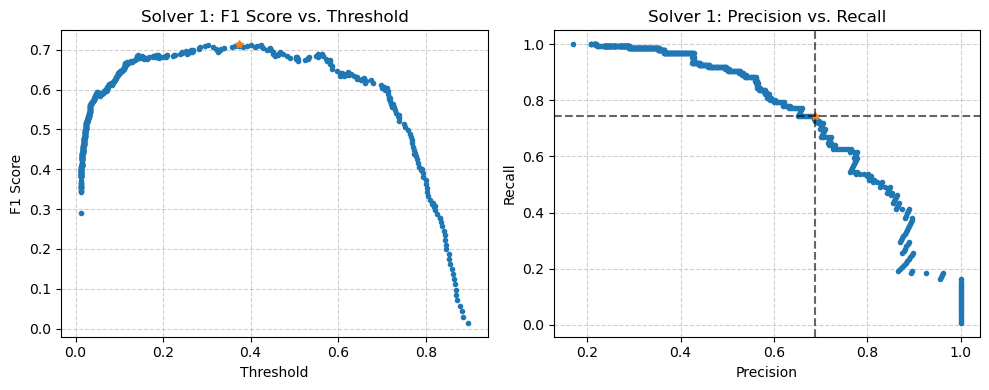

 Evaluating the 2 (out of 9) model... 


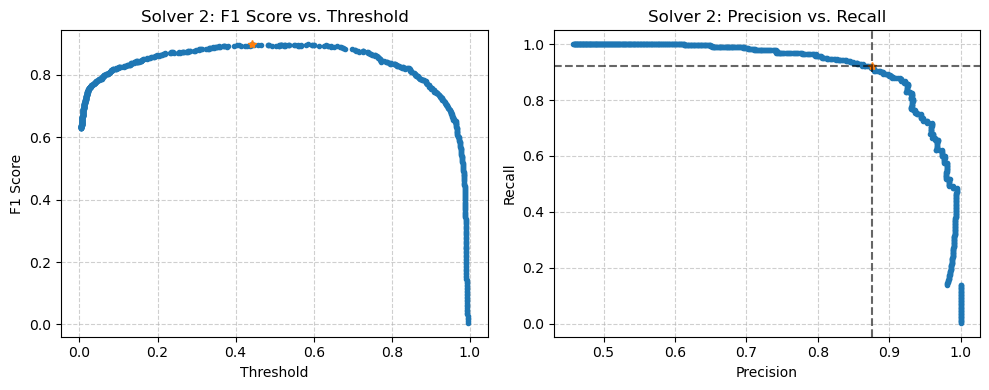

 Evaluating the 3 (out of 9) model... 


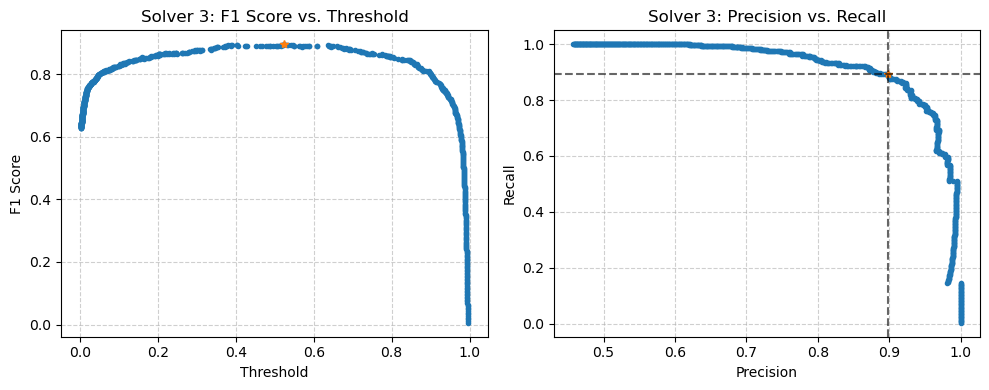

 Evaluating the 4 (out of 9) model... 


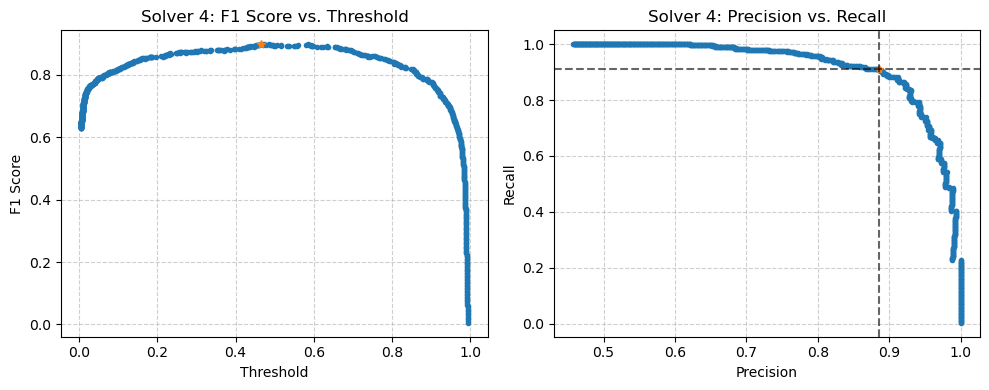

 Evaluating the 5 (out of 9) model... 


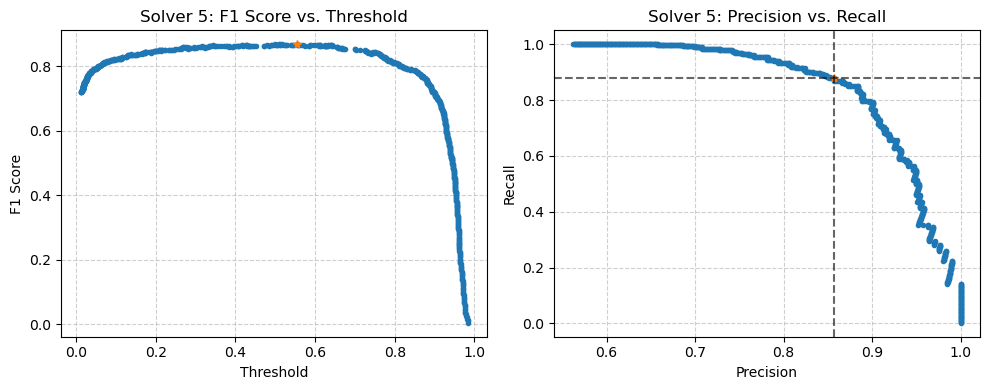

 Evaluating the 6 (out of 9) model... 


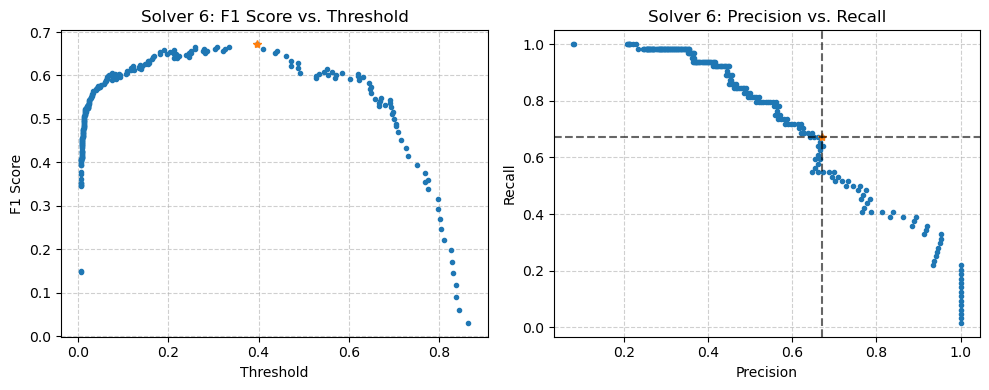

 Evaluating the 7 (out of 9) model... 


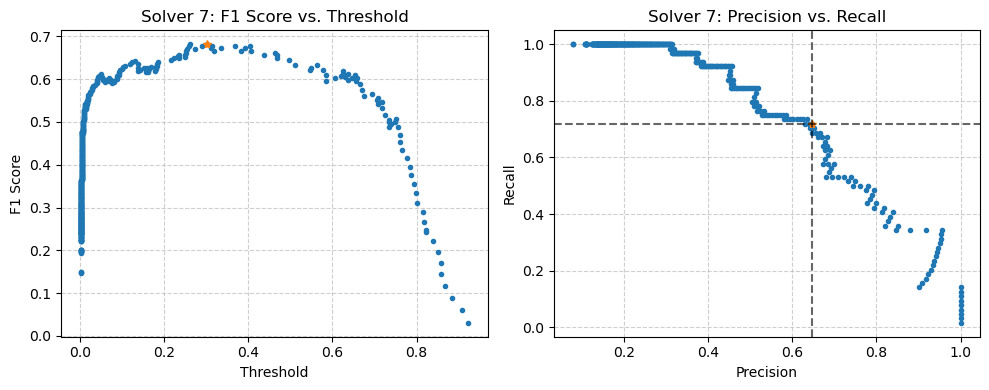

 Evaluating the 8 (out of 9) model... 


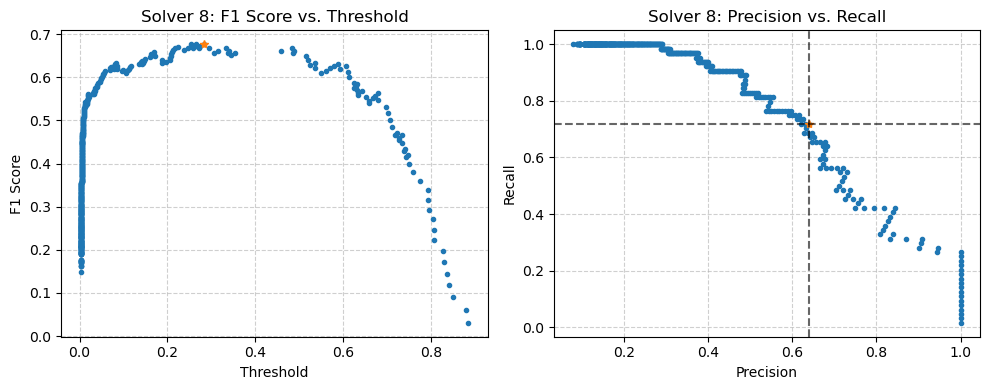

 Evaluating the 9 (out of 9) model... 


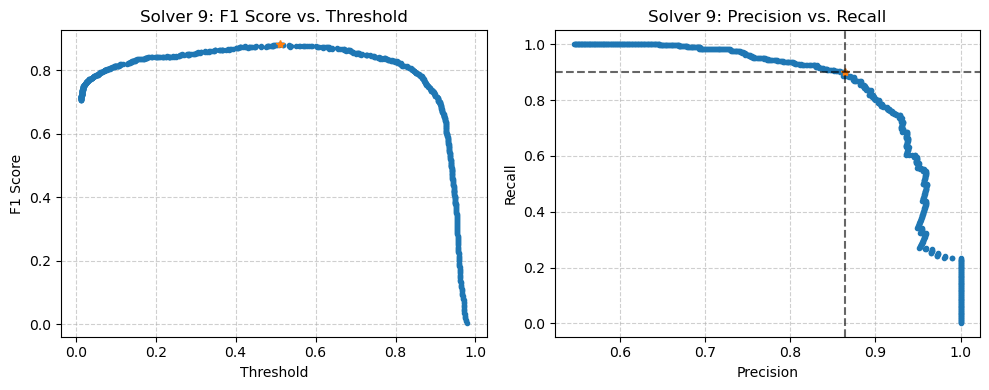

Macro F1 (test, best threshold): 0.805
Macro F1 (test, thr=0.5): 0.805


In [21]:
eps = 1e-12  # to avoid division by zero
beta = 1.0  # for F_beta; beta=1.0 means F1 score

best_thresholds = []
best_f1= []

per_solver_metrics = []
per_solver_metrics_05 = []
Yc_te_pred = np.zeros_like(Yc_te)
Yc_te_pred_05 = np.zeros_like(Yc_te)

prec = weights_df['train','scale_pos_weight'].values
for j, clf in enumerate(clf_models):
    print(f' Evaluating the {j+1} (out of {len(clf_models)}) model... ')
    
    y_val = Yc_val[:, j] # from validation set for threshold tuning
    p_val = clf.predict_proba(X_val)[:, 1]

    tag = None
    #if (j==0) or (j==5) or (j==6) &(j==7):
    #    tag = {'recall': 0.75}
    #else: tag = None
    best_t=best_threshold_from_pr(y_val, p_val, beta=beta, target= tag)
    best_thresholds.append(best_t)

    prec, rec, thr = precision_recall_curve(y_val, p_val)
    prec, rec = prec[:-1], rec[:-1]
    b2 = beta * beta
    f1s = (1 + b2) * (prec * rec) / (b2 * prec + rec + eps)

    kj =np.argmin((best_t - thr)**2)
    best_f1.append(f1s[kj])
#




    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Left: F1 vs threshold ---
    axes[0].plot(thr, f1s, '.')
    axes[0].plot(thr[kj], f1s[kj], '*' ) # for selected threshold
    axes[0].set_xlabel("Threshold")
    axes[0].set_ylabel("F1 Score")
    axes[0].set_title(f"Solver {j+1}: F1 Score vs. Threshold")
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # --- Right: Precision vs Recall ---
    axes[1].plot(prec, rec, '.')
    axes[1].plot(prec[kj], rec[kj], '*')
    axes[1].axhline(rec[kj], color='k', linestyle='--', alpha=0.6)
    axes[1].axvline(prec[kj], color='k', linestyle='--', alpha=0.6)
    axes[1].set_xlabel("Precision")
    axes[1].set_ylabel("Recall")
    axes[1].set_title(f"Solver {j+1}: Precision vs. Recall")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


    

    y_true = Yc_te[:, j]
    p_te = clf.predict_proba(X_te)[:, 1]

    
    y_pred_05 = (p_te >= 0.5).astype(int) # predictions at fixed 0.5 threshold
    y_pred = (p_te >= best_t).astype(int) # predictions at best threshold
    
    Yc_te_pred[:, j] = y_pred
    Yc_te_pred_05[:, j] = y_pred_05
    
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    
    pr_auc = average_precision_score(Yc_te[:, j], p_te)
    roc_auc = roc_auc_score(Yc_te[:, j], p_te)
    f1 = f1_score(Yc_te[:, j], y_pred, zero_division=0)

    per_solver_metrics.append({
        "Solver": j+1,
        "PR_AUC": pr_auc,
        "ROC_AUC": roc_auc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Positives": int(y_true.sum()),
        "Negatives": int(len(y_true) - y_true.sum())
    })

    precision = precision_score(y_true, y_pred_05, zero_division=0)
    recall = recall_score(y_true, y_pred_05, zero_division=0)
    acc = accuracy_score(y_true, y_pred_05)

    
    pr_auc = average_precision_score(Yc_te[:, j], p_te)
    roc_auc = roc_auc_score(Yc_te[:, j], p_te)
    f1 = f1_score(Yc_te[:, j], y_pred_05, zero_division=0)

    per_solver_metrics_05.append({
        "Solver": j+1,
        "PR_AUC": pr_auc,
        "ROC_AUC": roc_auc,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Positives": int(y_true.sum()),
        "Negatives": int(len(y_true) - y_true.sum())
    })


# Macro F1 across solvable labels
macro_f1 = float(np.mean([d["F1"] for d in per_solver_metrics])) 
print(f"Macro F1 (test, best threshold): {macro_f1:.3f}")

per_solver_metrics = pd.DataFrame(per_solver_metrics)



macro_f1_05 = float(np.mean([d["F1"] for d in per_solver_metrics_05])) 
print(f"Macro F1 (test, thr=0.5): {macro_f1:.3f}")

per_solver_metrics_05=pd.DataFrame(per_solver_metrics_05)

In [22]:
per_solver_metrics_05

,Solver,PR_AUC,ROC_AUC,F1,Precision,Recall,Accuracy,Positives,Negatives
0,1,0.814094,0.950390,0.761538,0.798387,0.727941,0.92250,136,664
1,2,0.957412,0.961780,0.875691,0.885475,0.866120,0.88750,366,434
2,3,0.959918,0.964563,0.878661,0.897436,0.860656,0.89125,366,434
3,4,0.958309,0.963417,0.875872,0.894587,0.857923,0.88875,366,434
4,5,0.910123,0.916038,0.880773,0.852391,0.911111,0.86125,450,350
5,6,0.751220,0.976287,0.728814,0.796296,0.671875,0.96000,64,736
6,7,0.770326,0.976202,0.755906,0.761905,0.750000,0.96125,64,736
7,8,0.709275,0.973866,0.746032,0.758065,0.734375,0.96000,64,736
8,9,0.933714,0.929364,0.874025,0.852174,0.897025,0.85875,437,363


In [23]:
per_solver_metrics

,Solver,PR_AUC,ROC_AUC,F1,Precision,Recall,Accuracy,Positives,Negatives
0,1,0.814094,0.950390,0.753521,0.722973,0.786765,0.91250,136,664
1,2,0.957412,0.961780,0.876011,0.864362,0.887978,0.88500,366,434
2,3,0.959918,0.964563,0.879888,0.900000,0.860656,0.89250,366,434
3,4,0.958309,0.963417,0.879121,0.883978,0.874317,0.89000,366,434
4,5,0.910123,0.916038,0.881134,0.865096,0.897778,0.86375,450,350
5,6,0.751220,0.976287,0.723077,0.712121,0.734375,0.95500,64,736
6,7,0.770326,0.976202,0.694444,0.625000,0.781250,0.94500,64,736
7,8,0.709275,0.973866,0.684932,0.609756,0.781250,0.94250,64,736
8,9,0.933714,0.929364,0.876682,0.859341,0.894737,0.86250,437,363


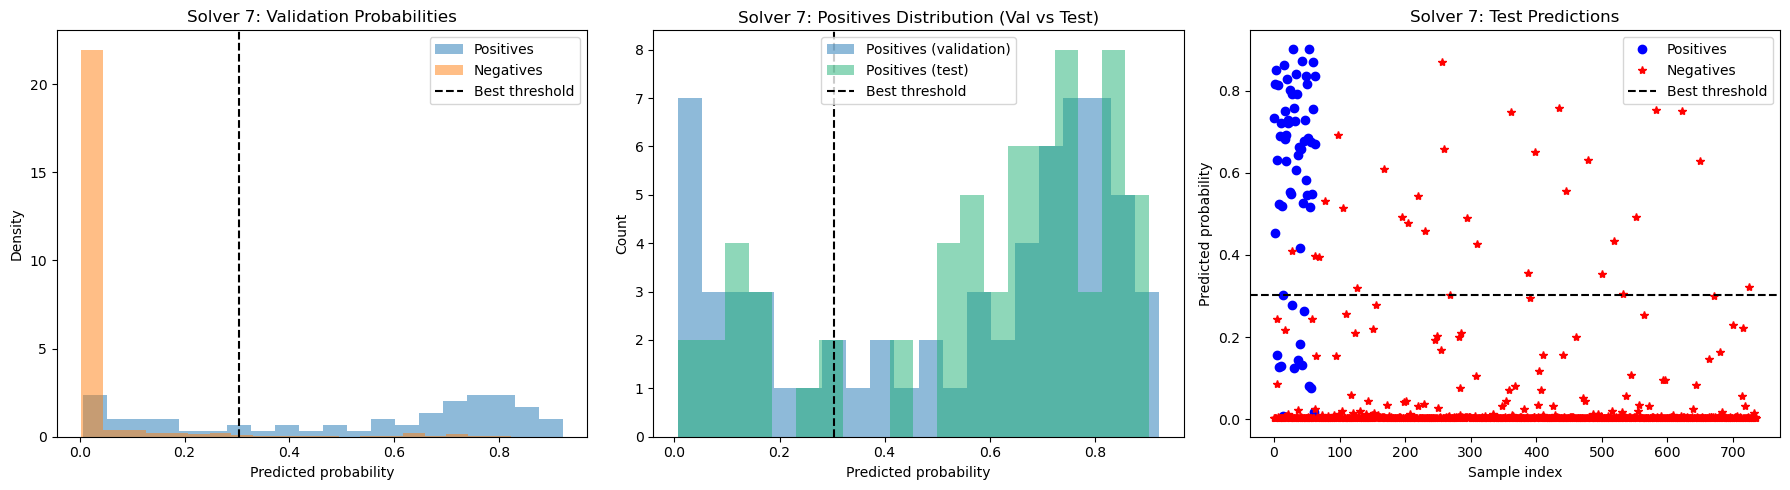

threshold: 0.303 for best F1: 0.681
Number of true positives (validation): 64 out of 800
Number of true positives (test): 64 out of 800


In [24]:

j = 6# solver j+1

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Left: predicted probability distributions (validation) ---
probs_val = clf_models[j].predict_proba(X_val)[:, 1]

axes[0].hist(probs_val[Yc_val[:, j] == 1], bins=20, alpha=0.5, label="Positives", density=True)
axes[0].hist(probs_val[Yc_val[:, j] == 0], bins=20, alpha=0.5, label="Negatives", density=True)
axes[0].axvline(best_thresholds[j], color='k', linestyle='--', label='Best threshold')

axes[0].set_xlabel("Predicted probability")
axes[0].set_ylabel("Density")
axes[0].set_title(f"Solver {j+1}: Validation Probabilities")
axes[0].legend()

# --- Middle: comparison of positives (validation vs test) ---
probs_te = clf_models[j].predict_proba(X_te)[:, 1]

axes[1].hist(probs_val[Yc_val[:, j] == 1], bins=20, alpha=0.5, label="Positives (validation)",color='#1f77b4')
axes[1].hist(probs_te[Yc_te[:, j] == 1], bins=20, alpha=0.5, label="Positives (test)",color="#1fb074")
axes[1].axvline(best_thresholds[j], color='k', linestyle='--', label='Best threshold')
axes[1].set_xlabel("Predicted probability")
axes[1].set_ylabel("Count")
axes[1].set_title(f"Solver {j+1}: Positives Distribution (Val vs Test)")
axes[1].legend()



# --- Right: scatter of test probabilities (positives vs negatives) ---
axes[2].plot(probs_te[Yc_te[:, j] == 1], 'bo', label="Positives")
axes[2].plot(probs_te[Yc_te[:, j] == 0], '*r', label="Negatives")
axes[2].axhline(best_thresholds[j], color='k', linestyle='--', label='Best threshold')
axes[2].set_xlabel("Sample index")
axes[2].set_ylabel("Predicted probability")
axes[2].set_title(f"Solver {j+1}: Test Predictions")
axes[2].legend()

plt.tight_layout()
plt.show()

# Print diagnostics
print(f"threshold: {best_thresholds[j]:.3f} for best F1: {best_f1[j]:.3f}")
print(f"Number of true positives (validation): {Yc_val[:, j].sum()} out of {len(Yc_val)}")
print(f"Number of true positives (test): {Yc_te[:, j].sum()} out of {len(Yc_te)}")


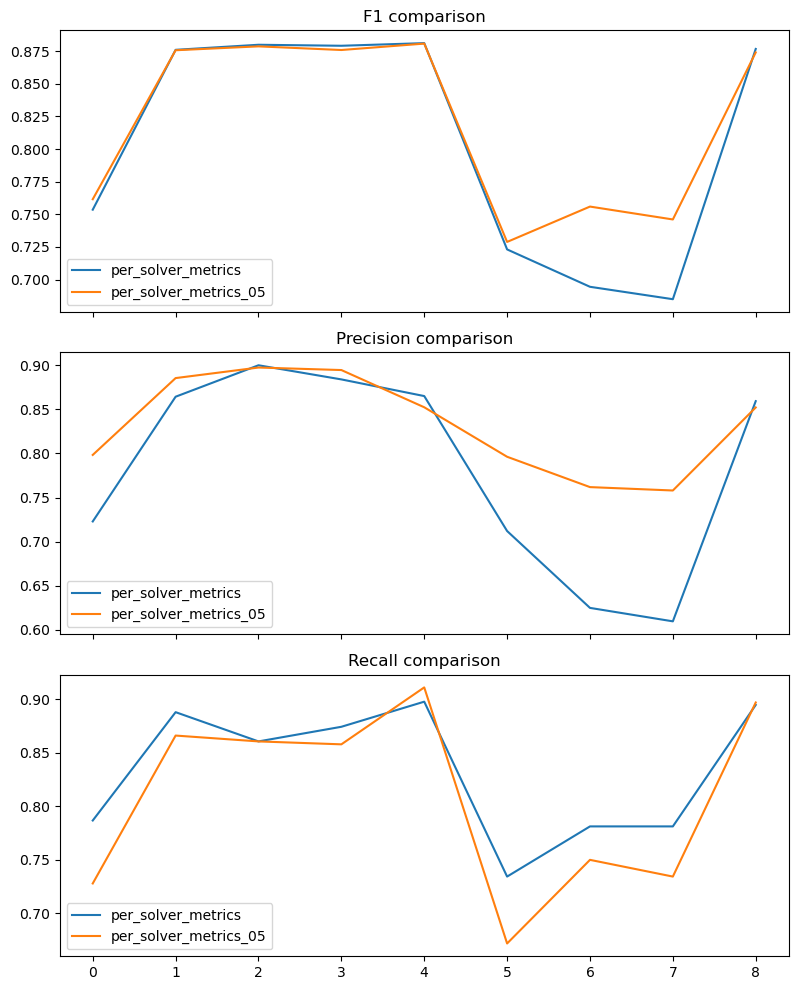

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# F1
axes[0].plot(per_solver_metrics["F1"], label="per_solver_metrics")
axes[0].plot(per_solver_metrics_05["F1"], label="per_solver_metrics_05")
axes[0].set_title("F1 comparison")
axes[0].legend()

# Precision
axes[1].plot(per_solver_metrics["Precision"], label="per_solver_metrics")
axes[1].plot(per_solver_metrics_05["Precision"], label="per_solver_metrics_05")
axes[1].set_title("Precision comparison")
axes[1].legend()

# Recall
axes[2].plot(per_solver_metrics["Recall"], label="per_solver_metrics")
axes[2].plot(per_solver_metrics_05["Recall"], label="per_solver_metrics_05")
axes[2].set_title("Recall comparison")
axes[2].legend()

plt.tight_layout()
plt.show()

# Regression part

Apply model selection similar to Classification task. This is however a simpler task, so one can simply select settings and train one type of model for all. 
A simpler model can be used too, e.g. linear regression model. However when tried it gave worse results.

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Train & select regression models per solver (for converged cases only)

m = Yr_tr.shape[1]

n_trials = 50  # same search budget as classification
display_every_n = 10  # increase if do not need verbose output  

reg_models = []
Maes = np.zeros((n_trials,m))
best_params_reg_per_solver = []
best_val_mae_per_solver = []

# --- base (shared) params for regression; candidates override some ---
reg_base_params = {
    "objective": "regression",
    "n_estimators": 5000,
    "learning_rate": 0.05,
    "max_depth": 8,
    "num_leaves": 16,
    "min_data_in_leaf": 30,
    "max_bin": 511,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.0,
    "lambda_l2": 1.0,
    "min_gain_to_split": 0.0,
    "random_state": 24,
    "n_jobs": -1,
    "verbose": -1,
}


rng = np.random.RandomState(24)

def reg_sample_params(rng):
    return {
        "learning_rate": rng.uniform(0.01, 0.1),
        "num_leaves": int(rng.randint(15, 64)),              # 15..63
        "max_depth": int(rng.choice([-1, 6, 8, 10])),
        "min_data_in_leaf": int(rng.randint(20, 101)),       # 20..100
        "max_bin": int(rng.choice([255, 511, 1023])),
        "feature_fraction": rng.uniform(0.6, 1.0),
        "bagging_fraction": rng.uniform(0.6, 1.0),
        "bagging_freq": int(rng.choice([0, 1, 5])),
        "lambda_l1": rng.uniform(0.0, 1.0),
        "lambda_l2": rng.uniform(0.0, 5.0),
        "min_gain_to_split": rng.uniform(0.0, 0.2),
    }



for j in range(m):
    print(f'Training & selecting regression for solver {j+1}/{m}...')

    # Use only rows where solver j converged in that split
    tr_mask  = (Yc_tr[:, j] == 1) 
    val_mask = (Yc_val[:, j] == 1)

    Xtr_j, ytr_j = X_tr[tr_mask],  Yr_tr[tr_mask,  j]  
    Xval_j, yval_j = X_val[val_mask], Yr_val[val_mask, j]

    best_mae = np.inf
    best_reg = None
    best_params = None

    
    for t in range(1, n_trials + 1):
        cand = {**reg_base_params, **reg_sample_params(rng)}
        reg = lgb.LGBMRegressor(**cand)

        reg.fit(
                Xtr_j, ytr_j,
                eval_set=[(Xval_j, yval_j)],
                eval_metric="l2",                          # stable for y = -log(T)
                callbacks=[lgb.early_stopping(200, verbose=False)],
                )
        # validation prediction & MAE in y-space
        yhat_val = reg.predict(Xval_j)
        mae = mean_absolute_error(yval_j, yhat_val)
        Maes[t-1,j]= mae
        
        if mae < best_mae:
            best_mae = mae
            best_reg = reg
            best_params = cand

        if t % display_every_n == 0 or t == n_trials:
            print(f"  trial {t}/{n_trials} | best val MAE so far: {best_mae:.4f}" )
            

       
       

    reg_models.append(best_reg)
    best_params_reg_per_solver.append(best_params)
    best_val_mae_per_solver.append(best_mae)
    print(f"✔ Solver {j+1}: selected reg model with val MAE = {best_mae:.4f}")
    
print("✔ Trained & selected best per-solver regressors based on validation MAE.")


Training & selecting regression for solver 1/9...
  trial 10/50 | best val MAE so far: 0.1212
  trial 20/50 | best val MAE so far: 0.1212
  trial 30/50 | best val MAE so far: 0.1212
  trial 40/50 | best val MAE so far: 0.1211
  trial 50/50 | best val MAE so far: 0.1189
✔ Solver 1: selected reg model with val MAE = 0.1189
Training & selecting regression for solver 2/9...
  trial 10/50 | best val MAE so far: 0.1158
  trial 20/50 | best val MAE so far: 0.1151
  trial 30/50 | best val MAE so far: 0.1151
  trial 40/50 | best val MAE so far: 0.1145
  trial 50/50 | best val MAE so far: 0.1145
✔ Solver 2: selected reg model with val MAE = 0.1145
Training & selecting regression for solver 3/9...
  trial 10/50 | best val MAE so far: 0.1273
  trial 20/50 | best val MAE so far: 0.1273
  trial 30/50 | best val MAE so far: 0.1266
  trial 40/50 | best val MAE so far: 0.1266
  trial 50/50 | best val MAE so far: 0.1261
✔ Solver 3: selected reg model with val MAE = 0.1261
Training & selecting regression

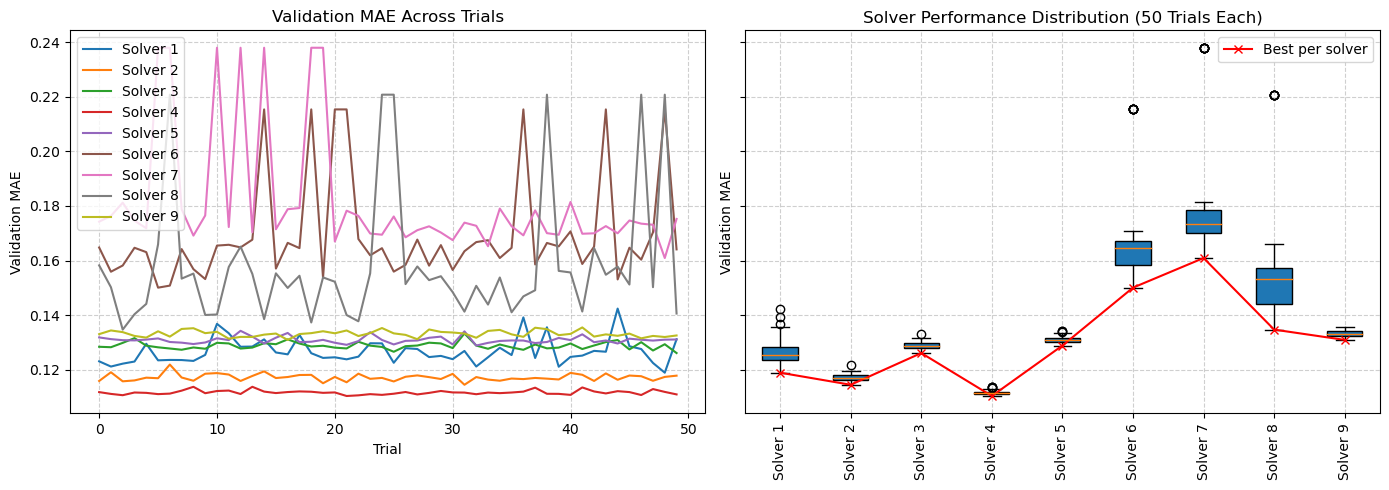

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Left plot: AP evolution over trials ---
for j in range(Maes.shape[1]):
    axes[0].plot(Maes[:, j], label=f"Solver {j+1}")
axes[0].set_xlabel("Trial")
axes[0].set_ylabel("Validation MAE")
axes[0].set_title("Validation MAE Across Trials")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.6)

# --- Right plot: Boxplot + best values ---
bp = axes[1].boxplot(
    Maes,
    labels=[f"Solver {j+1}" for j in range(Maes.shape[1])],
    patch_artist=True
)
# Overlay best values
x = np.arange(1, len(best_val_mae_per_solver) + 1)
axes[1].plot(x, best_val_mae_per_solver, '-x', color="red", label="Best per solver")
axes[1].set_xticklabels([f"Solver {j+1}" for j in range(Maes.shape[1])], rotation=90)
axes[1].set_ylabel("Validation MAE")
axes[1].set_title(f"Solver Performance Distribution ({n_trials} Trials Each)")
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

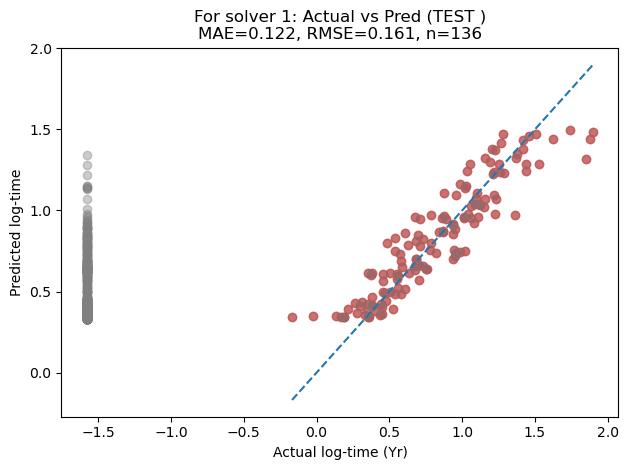

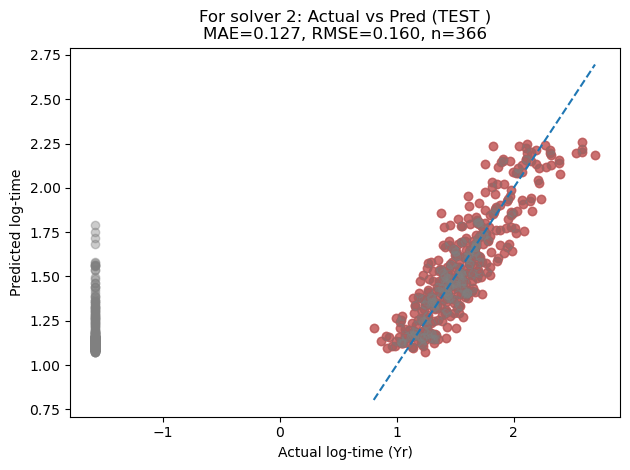

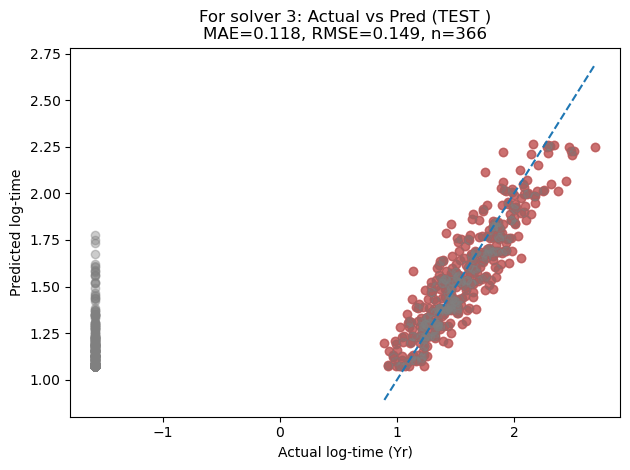

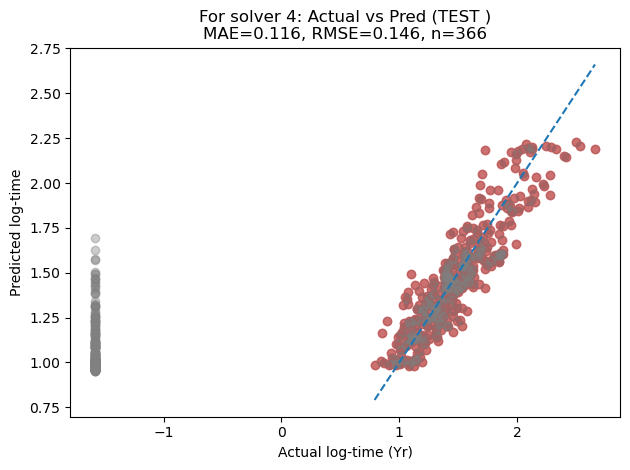

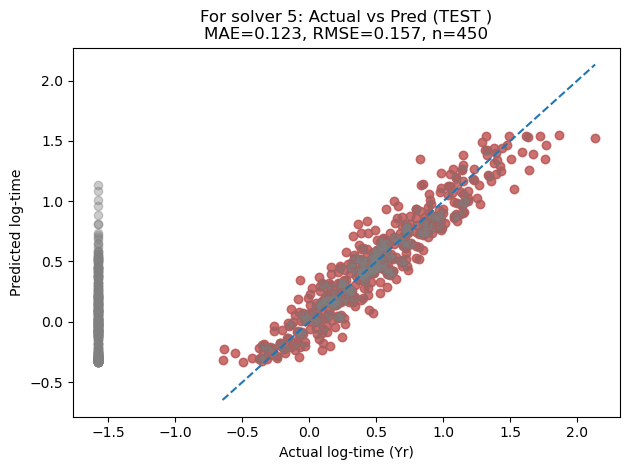

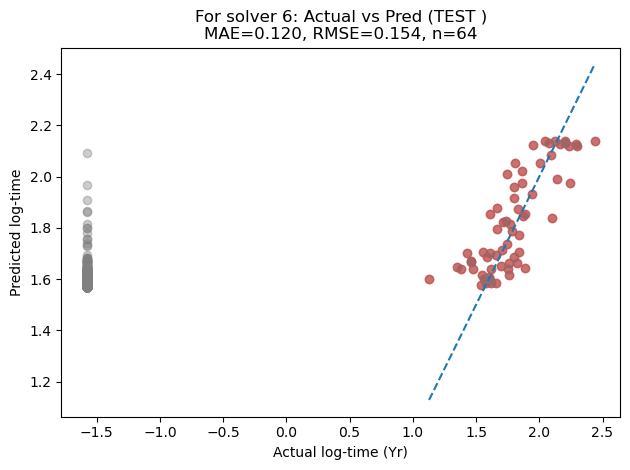

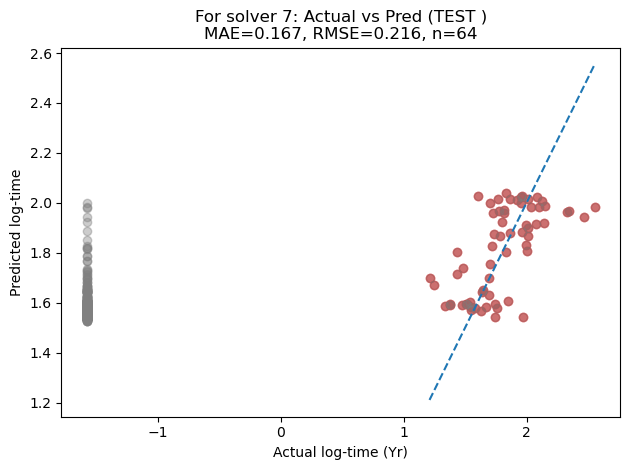

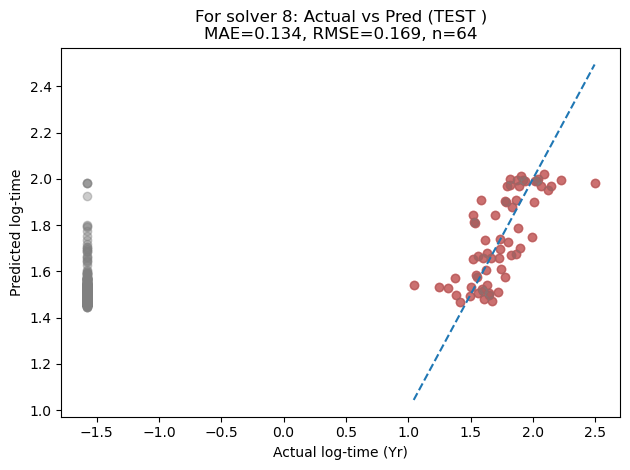

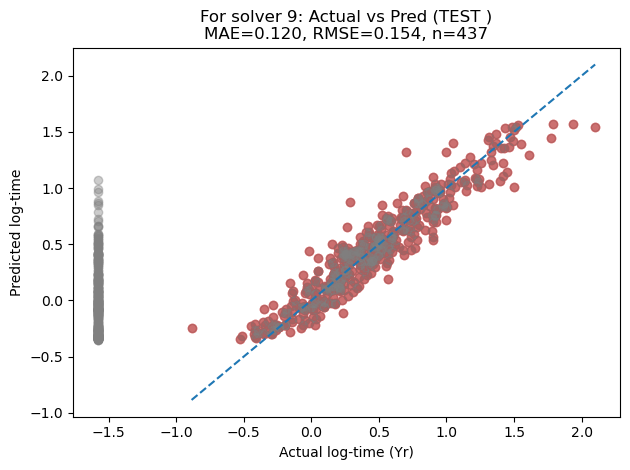


 Per-solver regression metrics (TEST):


,solver,n_test_conv,mae,rmse
0,1,136,0.122284,0.161033
1,2,366,0.127494,0.159554
2,3,366,0.118062,0.148539
3,4,366,0.115969,0.145725
4,5,450,0.122647,0.156878
5,6,64,0.119824,0.153780
6,7,64,0.167449,0.215505
7,8,64,0.133705,0.169114
8,9,437,0.119886,0.154339


In [28]:

results = []

for j in range(m):
        
    te_mask = (Yc_te[:, j] == 1)
    y_true = Yr_te[:, j]
    y_true_masked = Yr_te[te_mask, j]

    yhat = reg_models[j].predict(X_te); y_pred_masked = yhat[te_mask]
    
    mae = mean_absolute_error(y_true_masked, y_pred_masked)
    rmse = mean_squared_error(y_true_masked, y_pred_masked, squared=False)

    results.append({
            "solver": j+1,
            "n_test_conv": int(te_mask.sum()),
            "mae": mae,
            "rmse": rmse            
        })

        # --- Plots ---
       
    plt.figure()
    plt.scatter(y_true_masked, y_pred_masked, alpha=0.6, color='red')  # converged points in blue
    plt.scatter(y_true, yhat, alpha=0.4, color='gray')  # all points in gray
    lo, hi = min(y_true_masked.min(), y_pred_masked.min()), max(y_true_masked.max(), y_pred_masked.max())
    plt.plot([lo, hi], [lo, hi], linestyle="--")  # y = x
    plt.xlabel("Actual log-time (Yr)")
    plt.ylabel("Predicted log-time")
    plt.title(f"For solver {j+1}: Actual vs Pred (TEST )\n"
                  f"MAE={mae:.3f}, RMSE={rmse:.3f}, n={te_mask.sum()}")
    plt.tight_layout()
    plt.show()

 

df = pd.DataFrame(results)
print("\n Per-solver regression metrics (TEST):")
display(df)  





# Combine the two (Classification and Regression) in one prediction

There are some more inteleggent choices can be made to combine the two. I tried a few ad hoc ones. The most natural is however the hardETy, as P_pred is not a true probability and these are not well scaled beween each solver. 

In [29]:

N, m = Yr_te.shape


Yr_pred = np.zeros((N, m), dtype=float)
T_pred = np.zeros((N, m), dtype=float)

Yc_pred = np.zeros((N, m), dtype=float)
P_pred = np.zeros((N, m), dtype=float)

for j in range(m):
    # classical prediction
    P_pred[:,j] = clf_models[j].predict_proba(X_te)[:,1]; 
    Yc_pred[:,j] = (P_pred[:,j]>best_thresholds[j]) # Hard thresholding
    # regression prediction
    Yr_pred[:, j] = reg_models[j].predict(X_te); T_pred[:, j] = np.exp(-Yr_pred[:, j])  # back from log-time to time

# combined metrics to try:
softETy = P_pred  * Yr_pred + (1.0 - P_pred)*Y_penalty   # Soft, in log form, (N, m)    
softETt = P_pred  * T_pred + (1.0 - P_pred)* T_penalty   # Soft, in time (seconds), (N, m)

hardETy = Yc_pred  * Yr_pred + (1.0 - Yc_pred)* Y_penalty   # Hard, in log form, (N, m)    
hardETt = Yc_pred  * T_pred + (1.0 - Yc_pred)* T_penalty   # Hard, in time (seconds), (N, m)




In [30]:
#This is mask the times (y) based on the convergence (Yc)
def mask_the_chosen(Yc, chosen): 
    row_all_zero = (Yc.sum(axis=1) == 0)   
    chosen[row_all_zero] = -1
    return chosen

# This is a diagnostic function to report the failure rate of a chosen (based on your strategy) solver 
def failure_rate(Yc_true, Yr_true, chosen, label=""):
    N = len(chosen)

    true_best = mask_the_chosen(Yc_true,np.argmax(Yr_true, axis=1))  # (N,)
   
    #TEST = sum(Yc_true[i, true_best[i]] == 0 for i in range(N)  if true_best[i]>=0)
    #print(f"{label:15s} |  True best solver fails in {TEST}/{N} = {TEST/N:.3f} of cases.")  
   

    FP=sum(Yc_true[i, chosen[i]] == 0 for i in range(N) if chosen[i]>=0)  # predicted best fails (False Positives)
    FN= sum(1 for i in range(N) if chosen[i]==-1 and true_best[i]>=0)  # predicted no-solution but true best exists (False Negaties)
    num_failures = FP + FN;
    fr = num_failures / N
        
    
    aux = chosen - true_best
    num_agreed = np.sum(aux== 0); agr = num_agreed / N 
    num_both_diverged = np.sum((chosen == -1) & (true_best == -1)); agr_div = num_both_diverged / N; 
    num_both_converged = np.sum((chosen >= 0) & (true_best >= 0) & (aux == 0)); agr_conv = num_both_converged / N
    num_incorr = N - num_agreed - num_failures; inc = num_incorr / N
    
    print(f"{label:15s} |  Correct (diverged + best): {agr:.3f} (({num_both_diverged}+{num_both_converged})/{N}); Wrong as failed (FP+FN): {fr:.3f} (({FP}+{FN})/{N}), and incorrect: {inc:.3f} ({num_incorr}/{N})") 
    #print(f'Total sum check: {num_agreed + num_failures + num_incorr} = {N}')
    return agr, fr, inc
    

In [31]:


def fastest_of_topk(Yr, Yc, P, k=3):
    N, m = Yr.shape
    chosen = np.zeros(N, dtype=int)
    for i in range(N):
        topk = np.argsort(P[i])[-k:]  # indices of top-k probabilities
        best_in_topk = topk[np.argmax(Yr[i, topk])]  # among them, pick the one with highest Yr
        chosen[i] = best_in_topk
    chosen=mask_the_chosen(Yc,chosen)
    return chosen




strategies = {
    "softETy argmax": lambda: mask_the_chosen(Yc_pred,np.argmax(softETy, axis=1)),
    "hardETy argmax": lambda: mask_the_chosen(Yc_pred,np.argmax(hardETy, axis=1)),
    "Top 2 argmax":   lambda: fastest_of_topk(Yr_pred, Yc_pred, P_pred, k=2),
    "Score (Tr/P)":  lambda: mask_the_chosen(Yc_pred,np.argmin(hardETt/P_pred**1.6, axis=1)),
        }

# --- loop over them ---
for name, fn in strategies.items():
    chosen = fn()
    failure_rate(Yc_te, Yr_te, chosen, label=name)

softETy argmax  |  Correct (diverged + best): 0.535 ((234+194)/800); Wrong as failed (FP+FN): 0.151 ((69+52)/800), and incorrect: 0.314 (251/800)
hardETy argmax  |  Correct (diverged + best): 0.544 ((234+201)/800); Wrong as failed (FP+FN): 0.160 ((76+52)/800), and incorrect: 0.296 (237/800)
Top 2 argmax    |  Correct (diverged + best): 0.551 ((234+207)/800); Wrong as failed (FP+FN): 0.135 ((56+52)/800), and incorrect: 0.314 (251/800)
Score (Tr/P)    |  Correct (diverged + best): 0.537 ((234+196)/800); Wrong as failed (FP+FN): 0.155 ((72+52)/800), and incorrect: 0.307 (246/800)


Counter({-1: 271, 2: 153, 1: 144, 4: 127, 3: 63, 8: 33, 6: 4, 0: 3, 5: 2})
Counter({-1: 286, 1: 219, 2: 161, 4: 118, 8: 8, 3: 7, 0: 1})


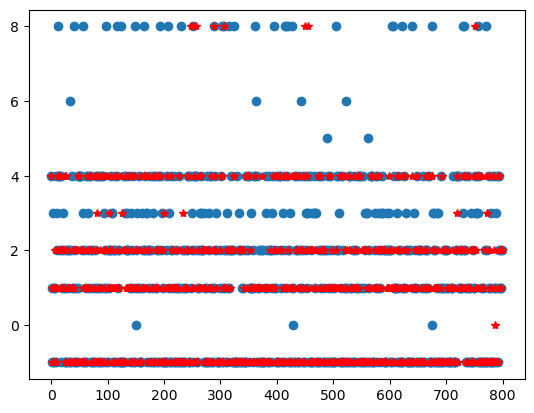

In [32]:
true_best = mask_the_chosen(Yc_te,np.argmax(Yr_te, axis=1))
chosen = mask_the_chosen(Yc_pred,np.argmax(hardETy, axis=1))
plt.plot(true_best, 'o')
plt.plot(chosen, '*r')
print(Counter(true_best))
print(Counter(chosen))

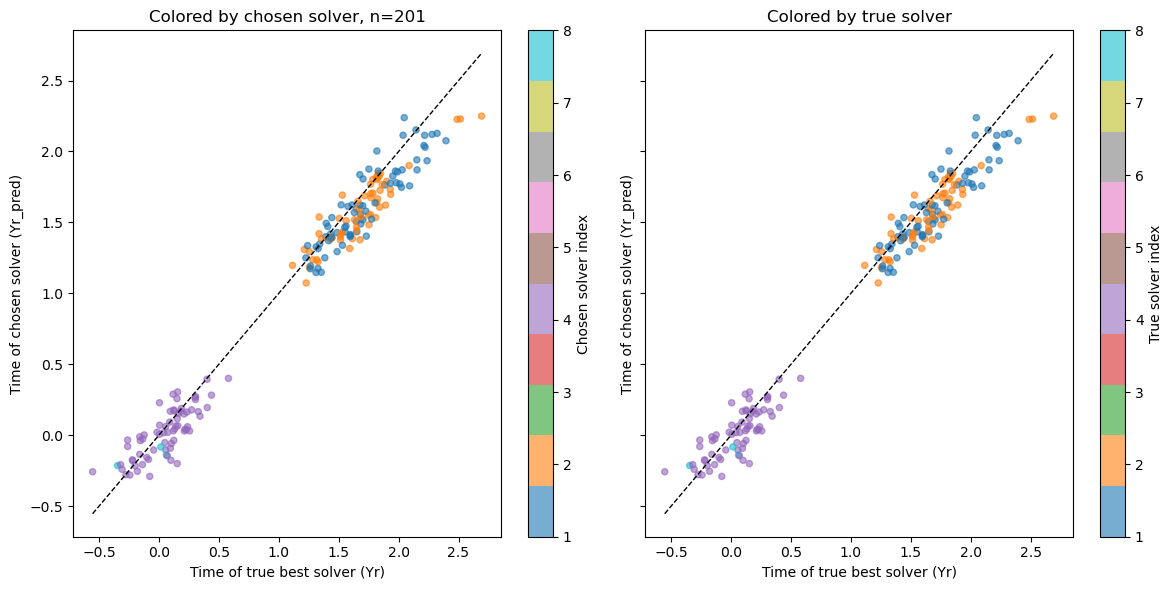

In [33]:

#mask = (true_best >= 0) & (chosen >= 0) # both converged but might not agree
mask = (true_best == chosen) & (chosen >= 0) # both agree and converged
#mask = (true_best != chosen) & (chosen >= 0) & (true_best >= 0) # both converged but disagree
#mask = (true_best >= 0)  # true converged

y_true_best = Yr_te[mask, true_best[mask]]
y_chosen    = hardETy[mask, chosen[mask]]
solver_idx_chosen = chosen[mask]   # which solver was picked
solver_idx_true   = true_best[mask]   # which solver truly correct

lo = np.min(np.concatenate([y_true_best, y_chosen]))
hi = np.max(np.concatenate([y_true_best, y_chosen]))

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# --- Plot 1: color by chosen solver ---
scatter1 = axes[0].scatter(
    y_true_best, y_chosen, 
    c=solver_idx_chosen, cmap="tab10", alpha=0.6, s=20
)
axes[0].plot([lo, hi], [lo, hi], "k--", linewidth=1)
axes[0].set_xlabel("Time of true best solver (Yr)")
axes[0].set_ylabel("Time of chosen solver (Yr_pred)")
axes[0].set_title(f"Colored by chosen solver, n={mask.sum()}")
cbar1 = fig.colorbar(scatter1, ax=axes[0])
cbar1.set_label("Chosen solver index")

# --- Plot 2: color by true solver ---
scatter2 = axes[1].scatter(
    y_true_best, y_chosen, 
    c=solver_idx_true, cmap="tab10", alpha=0.6, s=20
)
axes[1].plot([lo, hi], [lo, hi], "k--", linewidth=1)
axes[1].set_xlabel("Time of true best solver (Yr)")
axes[1].set_ylabel("Time of chosen solver (Yr_pred)")
axes[1].set_title("Colored by true solver")
cbar2 = fig.colorbar(scatter2, ax=axes[1])
cbar2.set_label("True solver index")

plt.tight_layout()
plt.show()


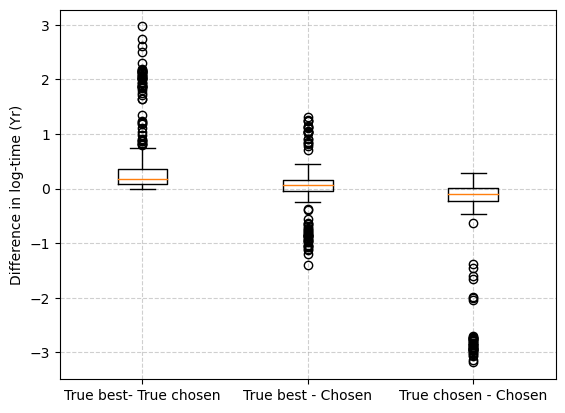

In [34]:

mask = (true_best != chosen) & (chosen >= 0) & (true_best >= 0) # both converged but disagree


y_true_best = Yr_te[mask, true_best[mask]]
y_chosen    = hardETy[mask, chosen[mask]]
y_true_chosen = Yr_te[mask, chosen[mask]]


plt.boxplot([ y_true_best - y_true_chosen, y_true_best - y_chosen, y_true_chosen - y_chosen], labels=["True best- True chosen", "True best - Chosen", "True chosen - Chosen"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylabel("Difference in log-time (Yr)")
plt.show()

correctly predicted is 0.905 
Counter({0: 484, 1: 109, 2: 91, 3: 89, 4: 15, 5: 9, 6: 3})
484/800 rows matched exactly.
[1. 1. 1. 1. 1. 1. 0. 1. 1.]
[1. 1. 1. 1. 1. 0. 0. 0. 1.]


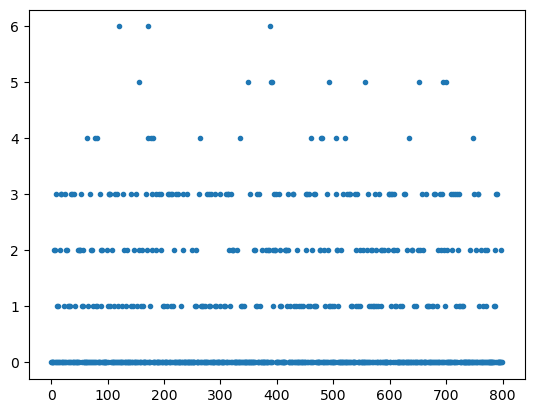

In [35]:
#plt.plot(P_pred - Yc_te,'*r')

corpr=np.sum((Yc_pred - Yc_te) ==0) / (N*m)
print(f'correctly predicted is {corpr:.3f} ' )

row_match = np.all(Yc_pred == Yc_te, axis=1)

hamming_dist = np.sum(Yc_pred != Yc_te, axis=1) # Hamming distance per row


plt.plot(hamming_dist,'.')
print(Counter(hamming_dist))

# Count how many rows matched
num_matched = np.sum(row_match)
print(f"{num_matched}/{len(row_match)} rows matched exactly.")


print(Yc_pred[5,:])
print(1.*Yc_te[5,:])

# Evaluate the results against  Basic Statistical Baselines

In [36]:

from scipy.optimize import root_scalar

def random_blind(N,m, rng = None):
    if rng is None:
        rng = np.random.RandomState(24)
    
    chosen=(rng.randint(0, m+1, size =N)-1)
    return chosen


def random_sighted(Yc_te, rng= None):
    N, m = Yc_te.shape
    if rng is None:
        rng = np.random.RandomState(24)
    
    chosen = rng.randint(0, m, size =N)
    return mask_the_chosen(Yc_te, chosen)



In [37]:
def informed_blind(Yc_tr, Yr_tr, N, m, rng=None):
    eps = 1e-12

    if rng is None:
        rng = np.random.RandomState(24)

    conv_rate = np.clip((Yc_tr == 1).mean(axis=0), eps, 1.0)

    true_best = mask_the_chosen(Yc_tr, np.argmax(Yr_tr, axis=1))
    q_none = true_best[true_best == -1].size / len(true_best)  # prior of no-convergence

    best_rate = np.zeros(m, dtype=float)
    for j in range(m):
        best_rate[j] = np.clip(np.mean(true_best == j), eps, 1.0)

    # --- calibration to ensure the probabilities are correct ---
    def f(c):
        return np.sum(np.log1p(-c * conv_rate)) - np.log(q_none)

    f0, f1 = f(0.0), f(1.0)
    if f1 > 0:
        c = 1.0
    else:
        sol = root_scalar(f, bracket=(0.0, 1.0), method='brentq', xtol=1e-10, rtol=1e-10)
        c = float(sol.root)
    # --------------------------------

    Yc_pred = (rng.rand(N, m) < c * conv_rate).astype(int)
    aux = Yc_pred * best_rate
    chosen = np.argmax(aux, axis=1)

    return mask_the_chosen(Yc_pred, chosen)


In [38]:

def informed_sighted(Yc_tr, Yr_tr, Yc_te, rng= None):
    eps = 1e-12

    if rng is None:
        rng = np.random.RandomState(24)
    m = Yc_te.shape[1] 
    
    true_best = mask_the_chosen(Yc_tr,np.argmax(Yr_tr, axis=1))
    best_rate = np.zeros(m, dtype=float)    # per-solver "best" rate
    for j in range(m):
        best_rate[j] = np.clip(np.mean(true_best == j), eps, 1.0)
        
    
    aux = Yc_te * best_rate
    chosen = np.argmax(aux, axis=1)  # among those predicted converged, pick the one with highest best_rate
    
    return mask_the_chosen(Yc_te, chosen)



def evaluate_baselines(Yc_tr, Yr_tr, Yc_te, Yr_te, seed=24):
    rng = np.random.RandomState(seed)
    N,m = Yc_te.shape

    baselines = {
        f"Random blind":                    lambda: random_blind(N,m, rng),
         "Informed blind":                  lambda: informed_blind(Yc_tr,Yr_tr,N,m, rng),
         "Random sighted":                  lambda: random_sighted(Yc_te, rng),
         "Informed sighted":                lambda: informed_sighted(Yc_tr,Yr_tr, Yc_te, rng),
         "ML - softEy":                     lambda: mask_the_chosen(Yc_pred, np.argmax(softETy, axis=1)),
         "ML - hardEy":                     lambda: mask_the_chosen(Yc_pred, np.argmax(hardETy, axis=1)),
         "ML - Top2":                       lambda: fastest_of_topk(Yr_pred, Yc_pred, P_pred, k=2),
         "Informed ML":                     lambda: informed_sighted(Yc_tr,Yr_tr, Yc_pred, rng),
             }

    results = {}
    for name, fn in baselines.items():
        chosen = fn()
        agr, fr, inc = failure_rate(Yc_te, Yr_te, chosen, label=name)
        results[name] = dict(correct=agr, failed=fr, incorrect=inc)
    return results



In [ ]:

results = evaluate_baselines(Yc_tr, Yr_tr, Yc_te, Yr_te, seed = 24)


Random blind    |  Correct (diverged + best): 0.115 ((37+55)/800); Wrong as failed (FP+FN): 0.647 ((460+58)/800), and incorrect: 0.237 (190/800)
Informed blind  |  Correct (diverged + best): 0.194 ((102+53)/800); Wrong as failed (FP+FN): 0.586 ((280+189)/800), and incorrect: 0.220 (176/800)
Random sighted  |  Correct (diverged + best): 0.426 ((271+70)/800); Wrong as failed (FP+FN): 0.340 ((272+0)/800), and incorrect: 0.234 (187/800)
Informed sighted |  Correct (diverged + best): 0.682 ((271+275)/800); Wrong as failed (FP+FN): 0.000 ((0+0)/800), and incorrect: 0.318 (254/800)
ML - softEy     |  Correct (diverged + best): 0.535 ((234+194)/800); Wrong as failed (FP+FN): 0.151 ((69+52)/800), and incorrect: 0.314 (251/800)
ML - hardEy     |  Correct (diverged + best): 0.544 ((234+201)/800); Wrong as failed (FP+FN): 0.160 ((76+52)/800), and incorrect: 0.296 (237/800)
ML - Top2       |  Correct (diverged + best): 0.551 ((234+207)/800); Wrong as failed (FP+FN): 0.135 ((56+52)/800), and incorre

In [40]:
# ---- Example call (assuming you already have Yc_tr, Yr_tr, Yc_te, Yr_te) ----
results = evaluate_baselines(Yc_tr, Yr_tr, Yc_te, Yr_te, seed = 24)

Random blind    |  Correct (diverged + best): 0.115 ((37+55)/800); Wrong as failed (FP+FN): 0.647 ((460+58)/800), and incorrect: 0.237 (190/800)
Informed blind  |  Correct (diverged + best): 0.194 ((102+53)/800); Wrong as failed (FP+FN): 0.586 ((280+189)/800), and incorrect: 0.220 (176/800)
Random sighted  |  Correct (diverged + best): 0.426 ((271+70)/800); Wrong as failed (FP+FN): 0.340 ((272+0)/800), and incorrect: 0.234 (187/800)
Informed sighted |  Correct (diverged + best): 0.682 ((271+275)/800); Wrong as failed (FP+FN): 0.000 ((0+0)/800), and incorrect: 0.318 (254/800)
ML - softEy     |  Correct (diverged + best): 0.535 ((234+194)/800); Wrong as failed (FP+FN): 0.151 ((69+52)/800), and incorrect: 0.314 (251/800)
ML - hardEy     |  Correct (diverged + best): 0.544 ((234+201)/800); Wrong as failed (FP+FN): 0.160 ((76+52)/800), and incorrect: 0.296 (237/800)
ML - Top2       |  Correct (diverged + best): 0.551 ((234+207)/800); Wrong as failed (FP+FN): 0.135 ((56+52)/800), and incorre